In [ ]:
#imports 
import mne
import numpy as np
import pandas as pd
import os
import glob
from matplotlib import pyplot
import sys

In [112]:
class eeg_dynamic_read:
    def __init__(self, file, montage_file):
        self.file=file
        self.montage=montage_file
    
    def read_eeg(self):
        eeg_type='read_'+self.file.split('.')[-1]
        method=getattr(self, eeg_type, lambda: 'Invalid Type')
        return method()
        
    def read_cnt(self):
        return mne.io.read_raw_cnt(self.file,self.montage)



class subject:
    def __init__(self, ID, data, montage, event_ids, sample_rate):
        self.ID=ID
        self.data=eeg_dynamic_read(data, montage).read_eeg()
        self.events=mne.find_events(self.data)
        self.event_ID=event_ids
        self.sample_rate=sample_rate
    
    def get_ERP(self, tmin=-.2, tmax=.8, baseline=(None,0.0), event=None, chans=[]):
        
        if not event:
            raise 'Event of Interest Must be specified'
        
        erp=mne.Epochs(self.data, events=self.events, event_id=self.event_ID, tmin=tmin,
                    tmax=tmax, baseline=baseline)
    
                                
        return erp[event].average(picks=mne.pick_channels(erp.info['ch_names'], chans))
    
    
    def get_chan(self, channels):
        #selects function based on user input type 
        #for conviencw in specification
        if isinstance(channels, list):
            return mne.pick_channels(self.data, channels)
        else:
            return mne.pick_channels_reexp(self.data, channels)
        


'''
class eeg_power: 
    def __init__(self, file_dir=None,  dataType='.cnt', montage=None):
        #search the whole directory tree for anything with the 
        #specified data type
        self.files=glob.glob(os.path.join(file_dir, ('*/*' + dataType)))                                
        self.montage=montage
        self.data=None
        self.dType
    
     def load_data(self, Nodes=None):
        #load method after intial init, this will give us the flexibility
        #to restart after node subsetting if we need to
            dats=[eeg_dynamic_read(file, self.montage).read_eeg(self.dType) for file in self.files]
'''                         
        
       

"\nclass eeg_power: \n    def __init__(self, file_dir=None,  dataType='.cnt', montage=None):\n        #search the whole directory tree for anything with the \n        #specified data type\n        self.files=glob.glob(os.path.join(file_dir, ('*/*' + dataType)))                                \n        self.montage=montage\n        self.data=None\n        self.dType\n    \n     def load_data(self, Nodes=None):\n        #load method after intial init, this will give us the flexibility\n        #to restart after node subsetting if we need to\n            dats=[eeg_dynamic_read(file, self.montage).read_eeg(self.dType) for file in self.files]\n"

In [90]:
direct='C:/Users/Phil/Box Sync/Classes/PSC_290_Final/'

#event mappings for the test data
evMaps={'Test': 1, 'Test2': 2, 'Test3': 3, 'Test48': 48, 'Test77': 77, 'Test88':88, 'Test100': 100, 'Test200' : 200}

In [113]:
subj=subject(ID='p', data=os.path.join(direct, 'data' ,'ObjectAttn_10_1.cnt'),
                       montage=os.path.join(direct, 'data','BP64_acti_64rows.sfp'), event_ids=evMaps, sample_rate=1000)

  Could not parse meas date from the header. Setting to None.


<ipython-input-112-a31275f98d8b>:12: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  return mne.io.read_raw_cnt(self.file,self.montage)


129 events found
Event IDs: [  1   2   3  48  77  88 100 200]


In [114]:
test_erp=subj.get_ERP(event='Test2', chans=['Fz'])

129 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


The graph shows test output for channel Fz at event code 2. Data are baselined in the interval -200ms - 0ms prior to stimulus onset. max time is 800ms

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-120-4661cd25d451>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  test_erp.plot()


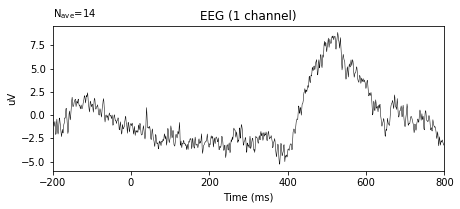

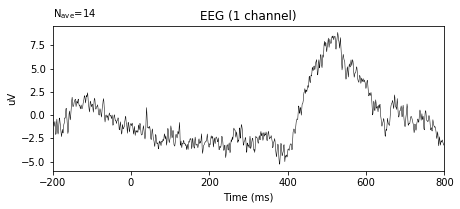

In [120]:
test_erp.plot()

In [ ]:
sys.getsizeof(subj)